In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse
from scanpro import scanpro, anova, t_test, sim_scanpro
from scanpro.linear_model import create_design
from scanpro.get_transformed_props import get_transformed_props
from upsetplot import UpSet
import decoupler as dc

sc._settings.ScanpyConfig(n_jobs=-1)

In [3]:
# Specify the path to your Helvetica Neue Regular font file
helvetica_neue_path = "/home/mstier/.local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object using the font path
prop_neue = fm.FontProperties(fname=helvetica_neue_path)

# Get the font name from FontProperties
helvetica_neue_name = prop_neue.get_name()

# Define custom context for font sizes and line thickness using Seaborn
custom_context = {
    'font.size': 7,                    # General font size for the plot
    'axes.labelsize': 7,               # Font size for axis labels
    'axes.titlesize': 7,               # Font size for titles
    'legend.fontsize': 7,              # Font size for legend
    'axes.linewidth': 0.6,             # Line width for axes spines
    'grid.linewidth': 0.6,             # Line width for grid lines
    'lines.linewidth': 0.6,            # Line width for plot lines
    'lines.markersize': 3,             # Size of markers in scatter/line plots
    'patch.linewidth': 0.6,            # Line width for boxplot edges
    'xtick.major.size': 3,             # Length of major ticks on x-axis
    'ytick.major.size': 3,             # Length of major ticks on y-axis
    'xtick.labelsize': 7,              # Font size for x-tick labels
    'ytick.labelsize': 7,              # Font size for y-tick labels
    'legend.title_fontsize': 7,        # Font size for legend title
}

# Define custom style for aesthetic elements like background, grid, and spines using Seaborn
custom_style = {
    'axes.facecolor': 'white',         # Background color of the axes
    'axes.edgecolor': 'black',         # Color of the border around the plot
    'axes.grid': False,                # Disable gridlines
    'grid.color': '#EAEAEA',           # Color of grid lines
    'grid.linestyle': '--',            # Style of the grid lines (dashed)
    'xtick.color': 'black',            # Color of x-axis tick labels
    'ytick.color': 'black',            # Color of y-axis tick labels
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',          # Direction of x-axis ticks
    'ytick.direction': 'out',          # Direction of y-axis ticks
    'axes.spines.left': True,          # Show the left spine (border)
    'axes.spines.bottom': True,        # Show the bottom spine (border)
    'axes.spines.right': False,        # Hide the right spine
    'axes.spines.top': False,          # Hide the top spine
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',                   # Set family to sans-serif
        'font.sans-serif': [helvetica_neue_name],      # Specify Helvetica Neue as the sans-serif font
        'font.size': 7,                                # General font size for the plot
        'axes.labelsize': 7,                           # Font size for axis labels
        'axes.titlesize': 7,                           # Font size for titles
        'legend.fontsize': 7,                          # Font size for legend
        'xtick.labelsize': 7,                          # Font size for x-tick labels
        'ytick.labelsize': 7                           # Font size for y-tick labels
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [4]:
# Set the base output directory for all figures
output_dir = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure4/'

In [5]:
adata = sc.read_h5ad('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure4/5kHVG-revised-sample-list_128-30-2/10069-MS_5kHVG-revised_UMAP-label-filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 644147 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'highlight', 'leiden-sub', 'celltype_coarse', 'celltype_fine', 'umap_x', 'umap_y', 'group_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', 'Biologic_Sex_colors', 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_coarse_colors', 'celltype_fine_colors', 'group_density_params', 'highlight_colors', 'hvg', 'leiden', 'leiden-sub_colors', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'
    ob

In [5]:
# Define custom colors for UMAP
custom_colors = {
    'CD14 Mono': '#A3A8E2',        # Lavender Blue
    'CD16 Mono': '#4D90A7',        # Darker Blue
    'cDC1': '#AB47BC',             # Purple
    'cDC2': '#F48FB1',             # Light Coral Pink
    'pDC': '#EF5350',              # Red Orange
    'AXL+ DC': '#66BB6A',          # Grass Green
    'HSPC': '#AED581',             # Yellow Green
    'Platelet/MK': '#9C9F76',      # Subdued Yellow Green

    'B Naive': '#FFD54F',          # Mustard Yellow
    'B Transitional': '#FFB74D',   # Mellow Apricot
    'B Memory': '#FF8A65',         # Pale Red
    'Plasmablast': '#B24D4D',      # Dark Red

    'CD4 T Naive': '#A1887F',      # Pale Brown
    'CD4 T Eff/EM': '#BBD5E2',     # Blue Grey
    'CD4 T CM': '#9575CD',         # Soft Purple
    'CD4 Treg': '#BA68C8',         # Light Purple
    'CD8 T Naive': '#7986CB',      # Lavender Blue
    'DN T': '#64B5F6',             # Light Blue
    'MAIT': '#4FC3F7',             # Vivid Sky Blue
    'Prolif Lymph': '#6DAF7B',     # Greeny Yellow

    'CD4 CTL': '#AED581',          # Yellow Green
    'CD8 T Eff/EM': '#FFEE58',     # Yellow
    'CD8 T CM': '#98A456',         # Olive Green
    'γδ T': '#FFCA28',             # Amber
    'NK': '#FFAB91',               # Salmon
    'NK CD56 Bright': '#BCAAA4',   # Taupe
    'ILC': '#0E0908'               # Dark Brown
}

<function matplotlib.pyplot.show(close=None, block=None)>

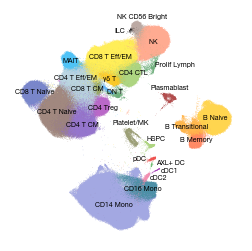

In [6]:
# Extract UMAP coordinates
umap_coords = adata.obsm['X_umap']

# Set figure size
fig, ax = plt.subplots(figsize=(3, 3))

# Create UMAP plot without automatic labels
sc.pl.umap(
    adata,
    color='celltype_fine',
    palette=custom_colors,
    frameon=False,
    size=0.5,
    show=False,
    legend_loc='none',
    ax=ax
)

# Plot each label at the centroid of its population, with manual adjustments for specified cell types
for cell_type in adata.obs['celltype_fine'].unique():
    # Find indices and coordinates of each cell type
    cell_indices = adata.obs['celltype_fine'] == cell_type
    cell_coords = umap_coords[cell_indices, :]
    centroid = np.mean(cell_coords, axis=0)

    # Manually adjust the position of specified cell types
    if cell_type == 'ILC':
        new_x, new_y = centroid[0] + (-1.3), centroid[1] + 0
    elif cell_type == 'Prolif Lymph':
        new_x, new_y = centroid[0] + (4.7), centroid[1] + (1.6)
    elif cell_type == 'CD8 T CM':
        new_x, new_y = centroid[0] + (-0.9), centroid[1] + 0
    elif cell_type == 'CD4 T Eff/EM':
        new_x, new_y = centroid[0] + (-0.5), centroid[1] + 1.1
    elif cell_type == 'CD8 T Eff/EM':
        new_x, new_y = centroid[0] + 0, centroid[1] + 0.3
    elif cell_type == 'Plasmablast':
        new_x, new_y = centroid[0] + 0, centroid[1] + 1.1
    elif cell_type == 'Platelet/MK':
        new_x, new_y = centroid[0] + 0, centroid[1] + 1.5
    elif cell_type == 'HSPC':
        new_x, new_y = centroid[0] + 0.7, centroid[1] + 0.7
    elif cell_type == 'pDC':
        new_x, new_y = centroid[0] + (-1.5), centroid[1] + 0
    elif cell_type == 'AXL+ DC':
        new_x, new_y = centroid[0] + 2.1, centroid[1] + 0.25
    elif cell_type == 'cDC1':
        new_x, new_y = centroid[0] + 1.45, centroid[1] + (-0.1)
    elif cell_type == 'cDC2':
        new_x, new_y = centroid[0] + 1.7, centroid[1] + 0.55
    elif cell_type == 'B Transitional':
        new_x, new_y = centroid[0] + (-0.5), centroid[1] + 0
    elif cell_type == 'B Naive':
        new_x, new_y = centroid[0] + 0, centroid[1] + 0.1
    elif cell_type == 'NK CD56 Bright':
        new_x, new_y = centroid[0] + 0.5, centroid[1] + 1.3
    elif cell_type == 'CD4 CTL':
        new_x, new_y = centroid[0] + 0.4, centroid[1] + 0.2
    elif cell_type == 'γδ T':
        new_x, new_y = centroid[0] + 0.05, centroid[1] + (-0.15)
    elif cell_type == 'CD14 Mono':
        new_x, new_y = centroid[0] + 0.2, centroid[1] + (-0.4)
    elif cell_type == 'CD16 Mono':
        new_x, new_y = centroid[0] + 0, centroid[1] + (-0.1)
    elif cell_type == 'CD4 T CM':
        new_x, new_y = centroid[0] + 0.4, centroid[1] + (-0.6)
    elif cell_type == 'CD4 T Naive':
        new_x, new_y = centroid[0] + (-0.2), centroid[1] + (-0.1)
    elif cell_type == 'CD4 Treg':
        new_x, new_y = centroid[0] + 0.6, centroid[1] + (-0.3)
    elif cell_type == 'DN T':
        new_x, new_y = centroid[0] + 1, centroid[1] + (-0.35)
    else:
        # For all other cell types, use the centroid
        new_x, new_y = centroid[0], centroid[1]

    # Place a label at the adjusted position for each cell type
    plt.text(new_x, new_y, cell_type, ha='center', va='center', fontsize=5)

    # Add your custom title here, or use '' for no title
    plt.title('')

# Save the plot
plt.savefig('UMAP-label.png', format='png', dpi=600, pad_inches=0)
plt.show

In [7]:
# List of marker genes
marker_genes = [
    'CD14', 'S100A8',
    'FCGR3A', 'MS4A7',
    'CCR7', 'TCF7',
    'LTB', 'IL32',
    'TSHZ2', 'FHIT',
    'FOXP3', 'IL2RA',
    'FGFBP2', 'GZMH',
    'CD8B', 'LINC02446',
    'CCL5', 'CST7',
    'LDHB', 'ANXA1',
    'TRDV2', 'TRGV9',
    'PTPN3', 'DTHD1',
    'SLC4A10', 'KLRB1',
    'NCAM1', 'SPON2',
    'KLRC1', 'XCL1',
    'MS4A1', 'TCL1A',
    'IGHD', 'LINC01857',
    'SSPN', 'COCH',
    'MZB1', 'PRDM1',
    'IL7R', 'KIT',
    'MKI67', 'TYMS',
    'CLEC9A', 'IDO1',
    'CD1C', 'FCER1A',
    'IL3RA', 'CCDC50',
    'AXL', 'SIGLEC6',
    'CD34', 'SPINK2',
    'PPBP', 'PF4'
]

celltype_order = [
    'CD14 Mono', 'CD16 Mono', 'CD4 T Naive', 'CD4 T Eff/EM', 'CD4 T CM',
    'CD4 Treg', 'CD4 CTL', 'CD8 T Naive', 'CD8 T Eff/EM', 'CD8 T CM',
    'γδ T', 'DN T', 'MAIT', 'NK', 'NK CD56 Bright', 'B Naive',
    'B Transitional', 'B Memory', 'Plasmablast', 'ILC', 'Prolif Lymph',
    'cDC1', 'cDC2', 'pDC', 'AXL+ DC', 'HSPC', 'Platelet/MK'
]

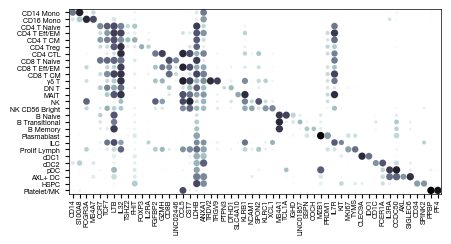

In [54]:
# Extract raw data which is already log normalized
adata_exp = adata.raw.to_adata()

# Subset for pre-selected marker genes
adata_subset = adata_exp[:, marker_genes]

# Scale data using MinMaxScaler
scaler = MinMaxScaler()
adata_scaled = adata_subset.X.toarray() if scipy.sparse.issparse(adata_subset.X) else adata_subset.X
adata_scaled = scaler.fit_transform(adata_scaled)

# Get cell type annotations from adata_filtered
cell_types = adata.obs['celltype_fine'].values

# Calculate mean expression and percent expressing cells for each marker per cell type
plot_data = []
for cell_type in np.unique(cell_types):
    indices = np.where(cell_types == cell_type)[0]
    scaled_subset = adata_scaled[indices]
    for gene_idx, gene in enumerate(marker_genes):
        mean_expression = np.mean(scaled_subset[:, gene_idx])
        percent_cells = np.sum(scaled_subset[:, gene_idx] > 0) / len(scaled_subset) * 100
        plot_data.append((cell_type, gene, mean_expression, percent_cells))

# Create a DataFrame for plotting
plot_df = pd.DataFrame(plot_data, columns=['celltype', 'genes', 'mean_expression', 'percent_cells'])

# Convert 'celltype' and 'genes' to categorical for correct plotting order
plot_df['celltype'] = pd.Categorical(plot_df['celltype'], categories=celltype_order, ordered=True)
plot_df['genes'] = pd.Categorical(plot_df['genes'], categories=marker_genes, ordered=True)

# Set up figure size to 4.3 x 2.1 inches
fig, ax = plt.subplots(figsize=(4.8, 2.4))

# Generate dot plot
sns.scatterplot(
    data=plot_df, x='genes', y='celltype', size='percent_cells', 
    hue='mean_expression', palette='bone_r', legend=None, sizes=(0.5, 30), ax=ax
)

# Adjust x-tick labels manually
ax.set_xticks(np.arange(len(marker_genes)))
ax.set_xticklabels([])

for i, label in enumerate(marker_genes):
    ax.text(i, len(celltype_order) + 0.2, label, rotation=90, fontsize=5, ha='center', va='top')

# Set y-ticks and labels
ax.set_yticks(np.arange(len(celltype_order)))
ax.set_yticklabels(celltype_order, fontsize=5)

# Adjust plot limits to minimize extra space
ax.set_xlim(-0.5, len(marker_genes) - 0.5)
ax.set_ylim(-0.5, len(celltype_order) - 0.5)

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Invert y-axis
ax.invert_yaxis()

# Add a complete outline (all 4 sides)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Set spine line width
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Save and show plot
plt.savefig('celltype_fine_markers_dotplot.svg', format='svg')
plt.show()

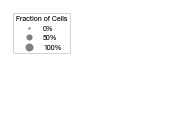

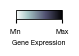

In [9]:
# Set up figure for legends separately
fig, ax = plt.subplots(figsize=(2, 1.5))  # Adjust size as needed
ax.axis('off')  # Remove axes

# Define size values and labels for dot size legend
size_values = [0.5, 15.25, 30]  # Adjusted sizes for matching the plot's scaling
size_labels = ['0%', '50%', '100%']

# Create legend handles for dot sizes
legend_handles = []
scaling_factor = 0.85  # Matches the scaling in the plot
for size, label in zip(size_values, size_labels):
    markersize = np.sqrt(size) * scaling_factor
    line = mlines.Line2D([], [], color='gray', marker='o', markersize=markersize, label=label, linestyle='None')
    legend_handles.append(line)

# Plot the dot size legend
legend1 = ax.legend(handles=legend_handles, title='Fraction of Cells', 
                    loc='upper left', frameon=True, handletextpad=1, fontsize=5, title_fontsize=5)
ax.add_artist(legend1)

# Create a color bar for mean expression
fig2, ax2 = plt.subplots(figsize=(0.6, 0.125))  # Adjust size as needed
cmap = plt.cm.bone_r
norm = Normalize(vmin=0, vmax=1)

# Create a horizontal color bar
cbar = ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Min', 'Max'])
cbar.set_label('Gene Expression', fontsize=5)

# Adjust color bar tick parameters
cbar.ax.tick_params(labelsize=5)
cbar.ax.xaxis.label.set_size(5)

# Save the figures and show legends
fig.savefig('Legend_DotSize.svg', format='svg')
fig2.savefig('Legend_ColorBar.svg', format='svg')

plt.show(fig)
plt.show(fig2)

In [10]:
# Coarse cell type proportionality analysis
np.random.seed(42)
out = scanpro(adata, clusters_col='celltype_coarse', samples_col='orig.ident', conds_col='Group', transform='logit')

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


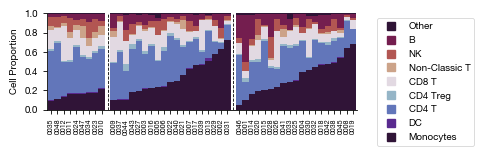

In [11]:
# Step 1: Extract 'orig.ident' and 'Group' information from the AnnData object
sample_groups = adata.obs[['orig.ident', 'Group']].drop_duplicates()

# Step 2: Merge the extracted group information with the proportionality results
props_df = out.props.reset_index()
merged_df = pd.merge(props_df, sample_groups, on='orig.ident')

# Step 3: Sort the DataFrame by 'Group' in the specified order (NHC, CI-NS, CI-Sep)
group_order = ['NHC', 'CI-NS', 'CI-Sep']
merged_df['Group'] = pd.Categorical(merged_df['Group'], categories=group_order, ordered=True)

# Step 4: Sort samples within each group by 'Monocytes' proportion
merged_df['Mono_rank'] = merged_df.groupby('Group')['Monocytes'].rank(method='first')
merged_df.sort_values(['Group', 'Mono_rank'], inplace=True)

# Step 5: Prepare data for plotting
cell_types = ['Monocytes', 'DC', 'CD4 T', 'CD4 Treg', 'CD8 T', 'Non-Classic T', 'NK', 'B', 'Other']  # Invert order
values = merged_df[cell_types].values.T  # Transpose for stacked bar plot

# Apply 'twilight_shifted' colormap for cell types
cmap = cm.get_cmap('twilight_shifted', len(cell_types))
celltype_colors = {cell_type: cmap(i) for i, cell_type in enumerate(cell_types)}

# Step 6: Create separate sections for each group
grouped_samples = [merged_df[merged_df['Group'] == group]['orig.ident'] for group in group_order]
grouped_values = [merged_df[merged_df['Group'] == group][cell_types].values.T for group in group_order]

# Define spacing parameters
intra_group_space = -0.2  # Reduced space between bars within a group
inter_group_space = 1.5  # Space between groups

# Calculate x-positions for the bars
x_positions = []
x_offset = 0

for group_samples in grouped_samples:
    n_samples = len(group_samples)
    group_positions = np.arange(n_samples) * (1 + intra_group_space) + x_offset
    x_positions.extend(group_positions)
    x_offset = group_positions[-1] + inter_group_space  # Add space for the next group

# Step 7: Plot stacked bar graph
fig, ax = plt.subplots(figsize=(4, 1.25))

# Stacked bar plot for each cell type (starting from Monocytes)
bottom = np.zeros(len(x_positions))
for i, cell_type in enumerate(cell_types):
    ax.bar(x_positions, np.hstack([group for group in grouped_values])[i], bottom=bottom, 
           color=celltype_colors.get(cell_type, '#7F7F7F'), label=cell_type)
    bottom += np.hstack([group for group in grouped_values])[i]

# Adjust x-ticks and labels
all_sample_ids = np.hstack([group for group in grouped_samples])
short_sample_ids = [sid.split('-')[-1] for sid in all_sample_ids]  # Only keep the last two digits
ax.set_xticks(x_positions)
ax.set_xticklabels(short_sample_ids, rotation=90, fontsize=5)  # Set x-tick label font size to 5

# Calculate positions for dashed lines centered in the white space between groups
dashed_line_positions = [
    (x_positions[len(grouped_samples[0]) - 1] + x_positions[len(grouped_samples[0])]) / 2,
    (x_positions[len(grouped_samples[0]) + len(grouped_samples[1]) - 1] + x_positions[len(grouped_samples[0]) + len(grouped_samples[1])]) / 2
]

# Add dashed vertical lines in the white space between groups
for pos in dashed_line_positions:
    ax.axvline(pos, color='black', linestyle='--', linewidth=0.6, zorder=0)  # Set line width to 0.6

# Set y-axis limit and ticks
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.2))  # Set y-ticks at specified intervals

# Set x-axis limits to eliminate extra white space
ax.set_xlim(x_positions[0] - 0.5, x_positions[-1] + 0.5)

# Adjust tick line width to 0.6
ax.tick_params(width=0.6)

# Add y-axis title
ax.set_ylabel('Cell Proportion')

# Create custom square markers for the legend
legend_handles = [
    mlines.Line2D([], [], color=celltype_colors[cell_type], marker='s', linestyle='None', markersize=6)
    for cell_type in reversed(cell_types)  # Invert to match the graph order
]

# Add legend with custom markers and font size 7
ax.legend(legend_handles, reversed(cell_types), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)

# Save and display plot
plt.savefig('proportions_coarse.svg', format='svg')
plt.show()

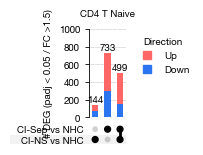

In [12]:
# Define paths to data files
df_ns_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4TNaive_CI-NS-vs-NHC.csv'
df_sep_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4TNaive_CI-Sep-vs-NHC.csv'

# Load the data
df_ns = pd.read_csv(df_ns_path, index_col=0)
df_sep = pd.read_csv(df_sep_path, index_col=0)

# Filter by padj and log2FoldChange thresholds
up_ns = df_ns[(df_ns['padj'] < 0.05) & (abs(df_ns['log2FoldChange']) > 0.58)].index
up_sep = df_sep[(df_sep['padj'] < 0.05) & (abs(df_sep['log2FoldChange']) > 0.58)].index

# Prepare Direction data
df_ns['Direction'] = df_ns['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')
df_sep['Direction'] = df_sep['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')

# Create membership dictionary
all_genes = list(set(up_ns) | set(up_sep))
membership = {
    'gene': all_genes,
    'CI-NS vs NHC': [gene in up_ns for gene in all_genes],
    'CI-Sep vs NHC': [gene in up_sep for gene in all_genes],
    'Direction': [(df_ns if gene in up_ns else df_sep).loc[gene, 'Direction'] for gene in all_genes]
}

# Create DataFrame and set indices for the UpSet plot
df = pd.DataFrame(membership).set_index(['CI-NS vs NHC', 'CI-Sep vs NHC'])
df['Direction'] = pd.Categorical(df['Direction'], categories=['Up', 'Down'], ordered=True)
df.sort_values('Direction', inplace=True)

# Create UpSet object with adjusted element size
upset = UpSet(
    df,
    subset_size='count',
    sort_categories_by='input',
    element_size=12,
    show_counts=True,  # Default count display
    totals_plot_elements=0,
    intersection_plot_elements=0
)

# Define colors for 'Direction'
direction_colors = {'Up': '#ff6666', 'Down': '#2b76f0'}

# Add stacked bars by 'Direction'
upset.add_stacked_bars(by='Direction', colors=direction_colors, elements=7)

# Plot the UpSet plot
plot = upset.plot()

# Add legend with inverted order
handles = [
    mlines.Line2D([], [], color=direction_colors[direction], label=direction, marker='s', linestyle='None', markersize=6) 
    for direction in ['Up', 'Down']
]
plt.legend(handles=handles, title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# Adjust y-axis ticks, limits, and tick width
plt.ylim(0, 1000)
plt.yticks(np.arange(0, 1001, 200))
plt.tick_params(axis='y', width=0.6)  # Set y-axis tick mark width to 0.6
plt.tick_params(axis='x', width=0.6)  # Set x-axis tick mark width to 0.6

# Add horizontal gridlines at y-ticks with 0.6-point width
for y_tick in np.arange(0, 1001, 200):
    plt.axhline(y=y_tick, color='lightgrey', linestyle='-', linewidth=0.6, zorder=0)

# Add title and y-axis label
plt.title('CD4 T Naive', y=1.05)
plt.ylabel('# DEG (padj < 0.05 / FC >1.5)')

# Save and display the plot
plt.savefig('Upset_CD4naive.svg', format='svg')
plt.show()

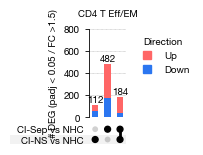

In [13]:
# Define paths to data files
df_ns_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4TEffEM_CI-NS-vs-NHC.csv'
df_sep_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4TEffEM_CI-Sep-vs-NHC.csv'

# Load the data
df_ns = pd.read_csv(df_ns_path, index_col=0)
df_sep = pd.read_csv(df_sep_path, index_col=0)

# Filter by padj and log2FoldChange thresholds
up_ns = df_ns[(df_ns['padj'] < 0.05) & (abs(df_ns['log2FoldChange']) > 0.58)].index
up_sep = df_sep[(df_sep['padj'] < 0.05) & (abs(df_sep['log2FoldChange']) > 0.58)].index

# Prepare Direction data
df_ns['Direction'] = df_ns['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')
df_sep['Direction'] = df_sep['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')

# Create membership dictionary
all_genes = list(set(up_ns) | set(up_sep))
membership = {
    'gene': all_genes,
    'CI-NS vs NHC': [gene in up_ns for gene in all_genes],
    'CI-Sep vs NHC': [gene in up_sep for gene in all_genes],
    'Direction': [(df_ns if gene in up_ns else df_sep).loc[gene, 'Direction'] for gene in all_genes]
}

# Create DataFrame and set indices for the UpSet plot
df = pd.DataFrame(membership).set_index(['CI-NS vs NHC', 'CI-Sep vs NHC'])
df['Direction'] = pd.Categorical(df['Direction'], categories=['Up', 'Down'], ordered=True)
df.sort_values('Direction', inplace=True)

# Create UpSet object with adjusted element size
upset = UpSet(
    df,
    subset_size='count',
    sort_categories_by='input',
    element_size=12,
    show_counts=True,  # Default count display
    totals_plot_elements=0,
    intersection_plot_elements=0
)

# Define colors for 'Direction'
direction_colors = {'Up': '#ff6666', 'Down': '#2b76f0'}

# Add stacked bars by 'Direction'
upset.add_stacked_bars(by='Direction', colors=direction_colors, elements=7)

# Plot the UpSet plot
plot = upset.plot()

# Add legend with inverted order
handles = [
    mlines.Line2D([], [], color=direction_colors[direction], label=direction, marker='s', linestyle='None', markersize=6) 
    for direction in ['Up', 'Down']
]
plt.legend(handles=handles, title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# Adjust y-axis ticks, limits, and tick width
plt.ylim(0, 800)
plt.yticks(np.arange(0, 801, 200))
plt.tick_params(axis='y', width=0.6)  # Set y-axis tick mark width to 0.6
plt.tick_params(axis='x', width=0.6)  # Set x-axis tick mark width to 0.6

# Add horizontal gridlines at y-ticks with 0.6-point width
for y_tick in np.arange(0, 1001, 200):
    plt.axhline(y=y_tick, color='lightgrey', linestyle='-', linewidth=0.6, zorder=0)

# Add title and y-axis label
plt.title('CD4 T Eff/EM', y=1.05)
plt.ylabel('# DEG (padj < 0.05 / FC >1.5)')

# Save and display the plot
plt.savefig('Upset_CD4TEffEM.svg', format='svg')
plt.show()

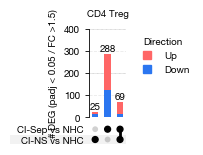

In [14]:
# Define paths to data files
df_ns_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4Treg_CI-NS-vs-NHC.csv'
df_sep_path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4Treg_CI-Sep-vs-NHC.csv'

# Load the data
df_ns = pd.read_csv(df_ns_path, index_col=0)
df_sep = pd.read_csv(df_sep_path, index_col=0)

# Filter by padj and log2FoldChange thresholds
up_ns = df_ns[(df_ns['padj'] < 0.05) & (abs(df_ns['log2FoldChange']) > 0.58)].index
up_sep = df_sep[(df_sep['padj'] < 0.05) & (abs(df_sep['log2FoldChange']) > 0.58)].index

# Prepare Direction data
df_ns['Direction'] = df_ns['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')
df_sep['Direction'] = df_sep['log2FoldChange'].apply(lambda x: 'Up' if x > 0 else 'Down')

# Create membership dictionary
all_genes = list(set(up_ns) | set(up_sep))
membership = {
    'gene': all_genes,
    'CI-NS vs NHC': [gene in up_ns for gene in all_genes],
    'CI-Sep vs NHC': [gene in up_sep for gene in all_genes],
    'Direction': [(df_ns if gene in up_ns else df_sep).loc[gene, 'Direction'] for gene in all_genes]
}

# Create DataFrame and set indices for the UpSet plot
df = pd.DataFrame(membership).set_index(['CI-NS vs NHC', 'CI-Sep vs NHC'])
df['Direction'] = pd.Categorical(df['Direction'], categories=['Up', 'Down'], ordered=True)
df.sort_values('Direction', inplace=True)

# Create UpSet object with adjusted element size
upset = UpSet(
    df,
    subset_size='count',
    sort_categories_by='input',
    element_size=12,
    show_counts=True,  # Default count display
    totals_plot_elements=0,
    intersection_plot_elements=0
)

# Define colors for 'Direction'
direction_colors = {'Up': '#ff6666', 'Down': '#2b76f0'}

# Add stacked bars by 'Direction'
upset.add_stacked_bars(by='Direction', colors=direction_colors, elements=7)

# Plot the UpSet plot
plot = upset.plot()

# Add legend with inverted order
handles = [
    mlines.Line2D([], [], color=direction_colors[direction], label=direction, marker='s', linestyle='None', markersize=6) 
    for direction in ['Up', 'Down']
]
plt.legend(handles=handles, title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# Adjust y-axis ticks, limits, and tick width
plt.ylim(0, 400)
plt.yticks(np.arange(0, 401, 100))
plt.tick_params(axis='y', width=0.6)  # Set y-axis tick mark width to 0.6
plt.tick_params(axis='x', width=0.6)  # Set x-axis tick mark width to 0.6

# Add horizontal gridlines at y-ticks with 0.6-point width
for y_tick in np.arange(0, 1001, 200):
    plt.axhline(y=y_tick, color='lightgrey', linestyle='-', linewidth=0.6, zorder=0)

# Add title and y-axis label
plt.title('CD4 Treg', y=1.05)
plt.ylabel('# DEG (padj < 0.05 / FC >1.5)')

# Save and display the plot
plt.savefig('Upset_CD4Treg.svg', format='svg')
plt.show()

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


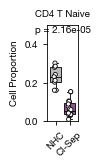

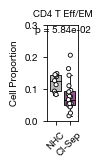

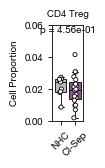

In [84]:
# Scanpro analysis for celltype_fine
out2 = scanpro(adata, clusters_col='celltype_fine', samples_col='orig.ident', conds_col='Group', conditions=['NHC', 'CI-Sep'], transform='logit')

# Create a new DataFrame from the celltype_fine proportionality analysis
fine_df = out2.props

# Extract the 'Group' column from adata.obs and ensure it aligns with fine_df
group_data = adata.obs[['Group', 'orig.ident']].drop_duplicates().set_index('orig.ident')

# Merge group information with fine_df
fine_df_merged = fine_df.merge(group_data, left_index=True, right_index=True, how='left')

# Define custom colors for each group
custom_palette = {"NHC": "#BBBBBB", "CI-Sep": "#9F4A96"}

# Define figure dimensions
width_in, height_in = 0.4, 1.25

# Extract the 'Group' column from adata.obs and ensure it aligns with fine_df
group_data = adata.obs[['Group', 'orig.ident']].drop_duplicates().set_index('orig.ident')

# Merge group information with fine_df
fine_df_merged = fine_df.merge(group_data, left_index=True, right_index=True, how='left')

# Specify the cell types to plot and their y-axis limits
selected_cell_types = {
    'CD4 T Naive': (0, 0.5),   # Example limit, adjust as needed
    'CD4 T Eff/EM': (0, 0.3),  # Example limit, adjust as needed
    'CD4 Treg': (0, 0.06)       # Example limit, adjust as needed
}

# Loop through each selected cell type to plot individually
for cell_type, y_limits in selected_cell_types.items():
    # Prepare data for plotting
    df_plot = fine_df_merged[[cell_type, 'Group']].copy()

    # Filter for NHC and CI-Sep only
    df_plot = df_plot[df_plot['Group'].isin(['NHC', 'CI-Sep'])]

    # Get p-adjusted value from scanpro results
    p_adj_value = out2.results.loc[cell_type, 'adjusted_p_values']

    # Create a figure for each plot
    fig, ax = plt.subplots(figsize=(width_in, height_in))

    # Boxplot
    sns.boxplot(
        ax=ax,
        x='Group',
        y=cell_type,
        data=df_plot,
        order=["NHC", "CI-Sep"],
        showfliers=False,
        linewidth=0.6,
        palette=custom_palette,
        boxprops={'edgecolor': 'black', 'linewidth': 0.6},
        whiskerprops={'color': 'black', 'linewidth': 0.6},
        capprops={'color': 'black', 'linewidth': 0.6},
        medianprops={'color': 'black', 'linewidth': 0.6}
    )

    # Stripplot for individual data points
    sns.stripplot(
        ax=ax,
        x='Group',
        y=cell_type,
        data=df_plot,
        order=["NHC", "CI-Sep"],
        jitter=True,
        dodge=True,
        marker='o',
        size=3,
        palette=['white'],  # White center
        edgecolor='black',  # Black outline
        linewidth=0.6
    )

    # Adjust Y-axis limits individually
    ax.set_ylim(y_limits)

    # Set plot title and labels
    ax.set_title(cell_type)
    ax.set_ylabel('Cell Proportion')
    ax.set_xlabel('')
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')

    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

    # Adjust x and y-axis tick marks to have a 0.6 pt line width
    ax.tick_params(axis='both', width=0.6)

    # Ensure spines on all four sides
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
        
    # Adjust X-axis limits to ensure proper spacing of categories
    ax.set_xlim(-0.6, 1.6)

    # Add p-adjusted value annotation
    p_value_text = f"p = {p_adj_value:.2e}"
    ax.text(0.5, y_limits[1] - ((y_limits[1] - y_limits[0]) * 0.1), p_value_text, 
            ha='center', va='bottom', color='black')

    # Save and display the plot
    file_name = f"{cell_type.replace(' ', '_').replace('/', '_')}_boxplot.svg"
    plt.savefig(os.path.join(output_dir, file_name), format='svg')
    plt.show()


Running GSEA for: CD4 T Naive
Running gsea on mat with 1 samples and 13560 targets for 47 sources.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


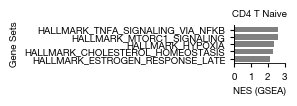


Running GSEA for: CD4 T Eff/EM
Running gsea on mat with 1 samples and 14457 targets for 48 sources.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


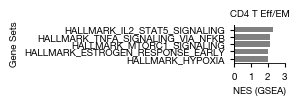


Running GSEA for: CD4 Treg
Running gsea on mat with 1 samples and 11186 targets for 47 sources.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


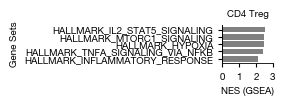

In [119]:
# File paths for each dataset
file_paths = {
    'CD4 T Naive': '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4TNaive_CI-Sep-vs-NHC.csv',
    'CD4 T Eff/EM': '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4TEffEM_CI-Sep-vs-NHC.csv',
    'CD4 Treg': '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/DESeq2 - DGE/DGE_CD4Treg_CI-Sep-vs-NHC.csv'
}

# Load MSigDB Hallmark gene sets
msigdb = dc.get_resource('MSigDB')
hallmark_msigdb = msigdb[(msigdb['collection'] == 'hallmark') & (~msigdb.duplicated(['geneset', 'genesymbol']))]

# Loop through each cell type and plot
for cell_type, file_path in file_paths.items():
    # Print label to indicate the current cell type being processed
    print(f"\nRunning GSEA for: {cell_type}")

    # Load DESeq2 results
    results_df = pd.read_csv(file_path, index_col=0)

    # Prepare the input matrix for GSEA
    mat = results_df[['stat']].T.rename(index={'stat': 'celltype'})

    # Run GSEA
    gsea_results = dc.run_gsea(
        mat=mat, 
        net=hallmark_msigdb, 
        source='geneset', 
        target='genesymbol', 
        times=1000, 
        min_n=15, 
        seed=42, 
        verbose=True
    )

    # Unpack the results
    gsea_estimate, gsea_norm, gsea_pvals = gsea_results

    # Combine GSEA results into a single DataFrame
    gsea_combined = pd.concat([gsea_estimate.T, gsea_norm.T, gsea_pvals.T], axis=1)
    gsea_combined.columns = ['Estimate', 'Normalized', 'P-value']

    # Filter for significant pathways (FDR-corrected p-value < 0.05)
    gsea_combined = gsea_combined[gsea_combined['P-value'] < 0.05]

    # Sort by normalized score and select the top 5
    top_gsea = gsea_combined.sort_values(by='Normalized', ascending=False).head(5)

    # Plotting the GSEA results for this cell type
    fig, ax = plt.subplots(figsize=(0.65, 0.5))  # Adjust the size as needed

    # Horizontal bar plot for NES
    ax.barh(top_gsea.index, top_gsea['Normalized'], color='gray', edgecolor='none')
    
    # Add vertical line at 0 for reference
    ax.axvline(0, color='black', linewidth=0.6)
    
    # Set x-axis limits and ticks
    ax.set_xlim(0, max(top_gsea['Normalized']) * 1.1)
    ax.set_xticks([0, 1, 2, 3])
    
    # Add labels and adjust aesthetics
    ax.set_xlabel('NES (GSEA)')
    ax.set_ylabel('Gene Sets')
    ax.set_title(cell_type)  # Add the cell type as the plot title
    ax.invert_yaxis()  # Invert y-axis to have the highest score at the top

    # Save the plot
    file_name = f"{cell_type.replace(' ', '_').replace('/', '_')}_GSEA_hallmark.svg"
    plt.savefig(file_name, format='svg')

    # Display the plot
    plt.show()


Running GSEA for: CD4 T Naive
Running gsea on mat with 1 samples and 13560 targets for 9 sources.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


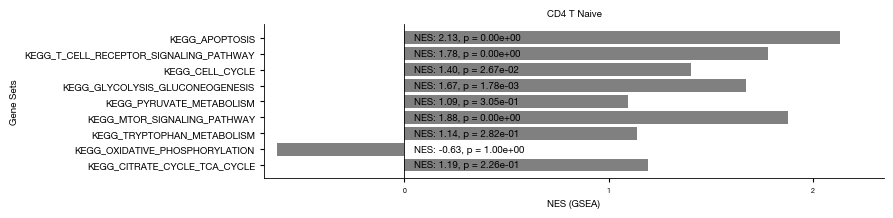


Running GSEA for: CD4 T Eff/EM
Running gsea on mat with 1 samples and 14457 targets for 9 sources.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


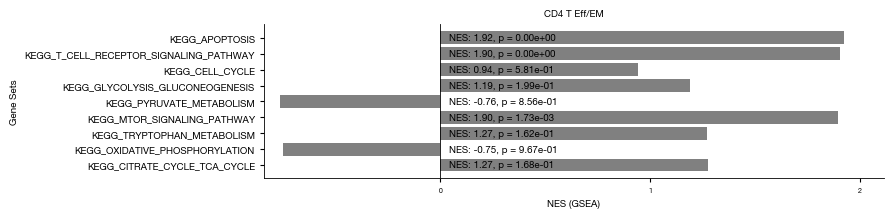


Running GSEA for: CD4 Treg
Running gsea on mat with 1 samples and 11186 targets for 8 sources.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


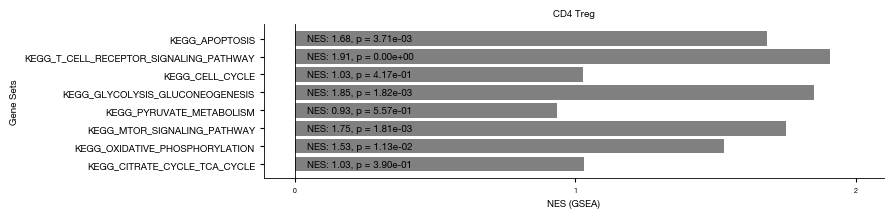

In [138]:
# Specify the list of KEGG pathways you're interested in
selected_kegg_pathways = [
    'KEGG_GLYCOLYSIS_GLUCONEOGENESIS',
    'KEGG_MTOR_SIGNALING_PATHWAY',
    'KEGG_PYRUVATE_METABOLISM',
    'KEGG_OXIDATIVE_PHOSPHORYLATION',
    'KEGG_CITRATE_CYCLE_TCA_CYCLE',
    'KEGG_APOPTOSIS',
    'KEGG_CELL_CYCLE',
    'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
    'KEGG_TRYPTOPHAN_METABOLISM'
]

# Load MSigDB KEGG gene sets
msigdb = dc.get_resource('MSigDB')
kegg_msigdb = msigdb[(msigdb['collection'] == 'kegg_pathways') & 
                     (msigdb['geneset'].isin(selected_kegg_pathways)) & 
                     (~msigdb.duplicated(['geneset', 'genesymbol']))]

# Initialize an empty DataFrame to store results
combined_results_df = pd.DataFrame(columns=['Cell Type', 'Pathway', 'NES', 'FDR-Adjusted P-Value'])

# Loop through each cell type and plot
for cell_type, file_path in file_paths.items():
    # Print label to indicate the current cell type being processed
    print(f"\nRunning GSEA for: {cell_type}")

    # Load DESeq2 results
    results_df = pd.read_csv(file_path, index_col=0)

    # Prepare the input matrix for GSEA
    mat = results_df[['stat']].T.rename(index={'stat': 'celltype'})

    # Run GSEA
    gsea_results = dc.run_gsea(
        mat=mat, 
        net=kegg_msigdb, 
        source='geneset', 
        target='genesymbol', 
        times=1000, 
        min_n=15, 
        seed=42, 
        verbose=True
    )

    # Unpack the results
    gsea_estimate, gsea_norm, gsea_pvals = gsea_results

    # Combine GSEA results into a single DataFrame
    gsea_combined = pd.concat([gsea_estimate.T, gsea_norm.T, gsea_pvals.T], axis=1)
    gsea_combined.columns = ['Estimate', 'Normalized', 'P-value']

    # Plotting the GSEA results for this cell type
    fig, ax = plt.subplots(figsize=(8, 2))

    # Horizontal bar plot for NES
    ax.barh(gsea_combined.index, gsea_combined['Normalized'], color='gray', edgecolor='none')

    # Calculate x-axis limits to show both positive and negative NES
    x_min = min(gsea_combined['Normalized'].min(), -0.1) * 1.1  # Add padding
    x_max = max(gsea_combined['Normalized'].max(), 0.1) * 1.1  # Add padding

    # Set x-axis limits and ticks
    ax.set_xlim(x_min, x_max)
    ax.set_xticks([x for x in range(int(x_min), int(x_max) + 1)])
    ax.tick_params(axis='x', labelsize=5)  # Set x-axis font size to 5

    # Add vertical line at 0 for reference
    ax.axvline(0, color='black', linewidth=0.6)
    
    # Add labels and adjust aesthetics
    ax.set_xlabel('NES (GSEA)')
    ax.set_ylabel('Gene Sets')
    ax.set_title(cell_type)
    ax.invert_yaxis()  # Invert y-axis to have the highest score at the top

    # Annotate each bar with the NES and FDR-adjusted p-value
    for i, (index, row) in enumerate(gsea_combined.iterrows()):
        annotation_text = f"NES: {row['Normalized']:.2f}, p = {row['P-value']:.2e}"
        ax.text(
            x_max * 0.02,  # Place the text a bit beyond the right end of the bar plot
            i,             # Position along the y-axis
            annotation_text,
            va='center',   # Center vertically
            ha='left',     # Align to the left
            fontsize=7,
            color='black'
        )

    # Display the plot
    plt.show()


Plotting running score for: CD4 T Naive - KEGG_GLYCOLYSIS_GLUCONEOGENESIS


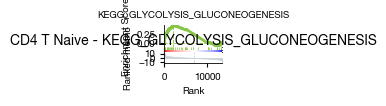


Plotting running score for: CD4 T Naive - KEGG_OXIDATIVE_PHOSPHORYLATION


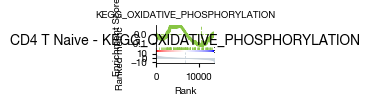


Plotting running score for: CD4 T Eff/EM - KEGG_GLYCOLYSIS_GLUCONEOGENESIS


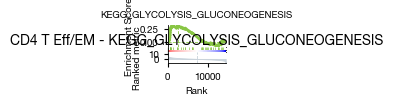


Plotting running score for: CD4 T Eff/EM - KEGG_OXIDATIVE_PHOSPHORYLATION


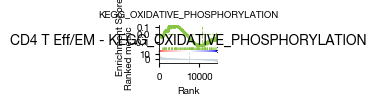


Plotting running score for: CD4 Treg - KEGG_GLYCOLYSIS_GLUCONEOGENESIS


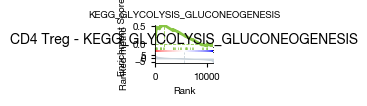


Plotting running score for: CD4 Treg - KEGG_OXIDATIVE_PHOSPHORYLATION


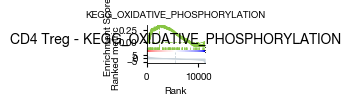

In [137]:
# Define the KEGG pathways of interest
selected_pathways = [
    'KEGG_GLYCOLYSIS_GLUCONEOGENESIS',
    'KEGG_OXIDATIVE_PHOSPHORYLATION'
]

# Loop through each cell type and plot running scores for each specified pathway
for cell_type, file_path in file_paths.items():
    # Load DESeq2 results
    results_df = pd.read_csv(file_path, index_col=0)

    # Loop through each pathway of interest
    for pathway in selected_pathways:
        print(f"\nPlotting running score for: {cell_type} - {pathway}")

        # Plot the running score for the current pathway
        ax = dc.plot_running_score(
            df=results_df,
            stat='stat',
            net=kegg_msigdb,
            source='geneset',
            target='genesymbol',
            set_name=pathway,
            figsize=(0.75, 0.5),
            cmap='seismic'
        )

        # Define the file name and save the plot as .svg
        file_name = f"{cell_type.replace(' ', '_').replace('/', '_')}_{pathway}.svg"
        plt.savefig(os.path.join(output_dir, file_name), format='svg')

        # Add a label for the cell type on the plot
        plt.title(f"{cell_type} - {pathway}", fontsize=10)
        plt.show()

In [151]:
# Load Raw Label Filtered AnnData object
adata_raw = sc.read_h5ad('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure5/5kHVG-revised-sample-list_128-30-2/10069-MS_raw_label-filtered.h5ad')

# Generate pseudobulks by sample and cell type
pdata = dc.get_pseudobulk(
    adata_raw,
    sample_col='orig.ident',
    groups_col='celltype_fine',
    mode='sum',
    min_cells=20,
    min_counts=1000,
)
pdata

AnnData object with n_obs × n_vars = 862 × 32173
    obs: 'orig.ident', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', 'celltype_coarse', 'celltype_fine', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

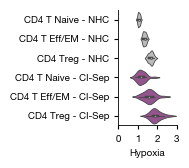

In [190]:
# Load the PROGENy model for human data, using the top 500 most responsive genes
progeny = dc.get_progeny(organism='human', top=500)

# Normalize total counts per pseudobulk sample to 1e6 (Counts Per Million)
sc.pp.normalize_total(pdata, target_sum=1e6)

# Run the MLM for pathway activity inference on pdata
mlm_results = dc.run_mlm(
    mat=pdata,
    net=progeny,
    use_raw=False,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

# Extract mlm estimates
acts = dc.get_acts(pdata, obsm_key='mlm_estimate')

# Subset 'acts' to include only NHC and CI-Sep groups and specified cell types
acts_subset = acts[
    (acts.obs['Group'].isin(['NHC', 'CI-Sep'])) & 
    (acts.obs['celltype_fine'].isin(['CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg']))
].copy()

# Create a new column that combines 'celltype_fine' and 'Group'
acts_subset.obs['celltype_group'] = acts_subset.obs['celltype_fine'].astype(str) + " - " + acts_subset.obs['Group'].astype(str)

# Extract 'Hypoxia' pathway values from .X and flatten it
hypoxia_scores = acts_subset[:, 'Hypoxia'].X.toarray().flatten()

# Add 'Hypoxia' scores as a new column to obs
acts_subset.obs['Hypoxia'] = hypoxia_scores

# Define the custom order
custom_order = [
    'CD4 T Naive - NHC',
    'CD4 T Eff/EM - NHC',
    'CD4 Treg - NHC',
    'CD4 T Naive - CI-Sep',
    'CD4 T Eff/EM - CI-Sep',
    'CD4 Treg - CI-Sep'
]

# Define the custom color palette
custom_palette = {
    'CD4 T Naive - NHC': '#BBBBBB',   # Gray for NHC
    'CD4 T Eff/EM - NHC': '#BBBBBB',
    'CD4 Treg - NHC': '#BBBBBB',
    'CD4 T Naive - CI-Sep': '#9F4A96',  # Purple for CI-Sep
    'CD4 T Eff/EM - CI-Sep': '#9F4A96',
    'CD4 Treg - CI-Sep': '#9F4A96'
}

# Set up the figure dimensions
fig, ax = plt.subplots(figsize=(0.75, 1.5))

# Create a horizontal violin plot for 'Hypoxia' with the specified order
sns.violinplot(
    data=acts_subset.obs, 
    y='celltype_group', 
    x='Hypoxia', 
    scale='width', 
    inner='box', 
    palette=custom_palette, 
    order=custom_order,  # Set the custom order for y-axis
    ax=ax
)

# Customize the x-axis limits and ticks
ax.set_xlim(0, 3)
ax.set_xticks([0, 1, 2, 3])

# Adjust the labels and aesthetics
ax.set_xlabel('Hypoxia')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.savefig('PROGENy_hypoxia.svg', format='svg')
plt.show()

In [192]:
cell_types_of_interest = ['CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg']

# Filter to include only NHC and CI-Sep groups within the specified cell types
adata_subset = adata[(adata.obs['Group'].isin(['NHC', 'CI-Sep'])) & 
                     (adata.obs['celltype_fine'].isin(cell_types_of_interest))].copy()

AnnData object with n_obs × n_vars = 166004 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'highlight', 'leiden-sub', 'celltype_coarse', 'celltype_fine', 'umap_x', 'umap_y', 'group_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', 'Biologic_Sex_colors', 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_coarse_colors', 'celltype_fine_colors', 'group_density_params', 'highlight_colors', 'hvg', 'leiden', 'leiden-sub_colors', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'
    ob

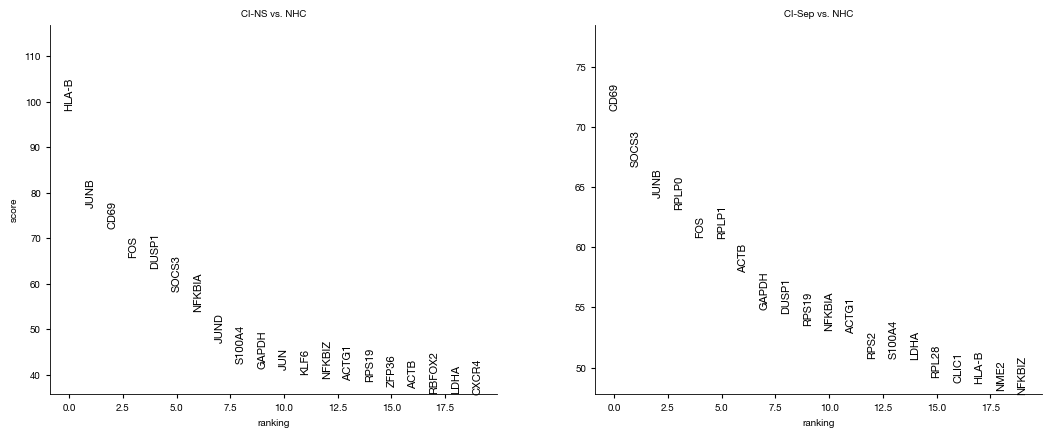

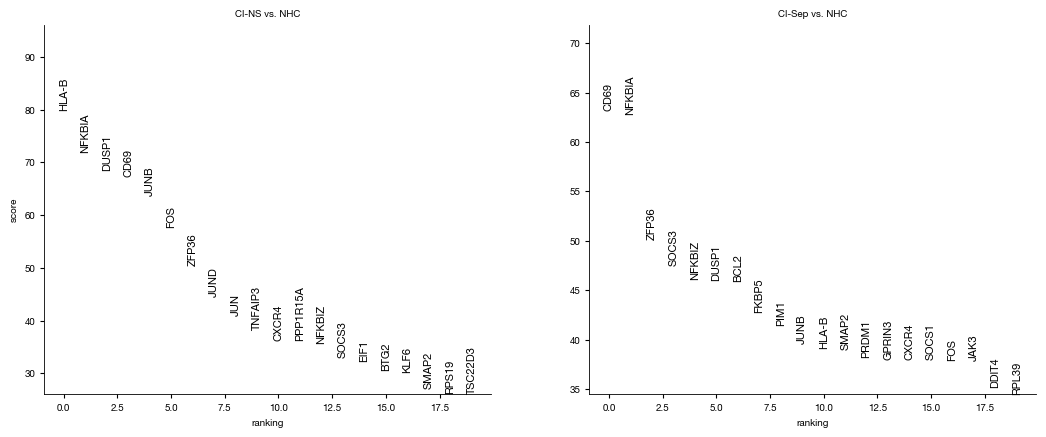

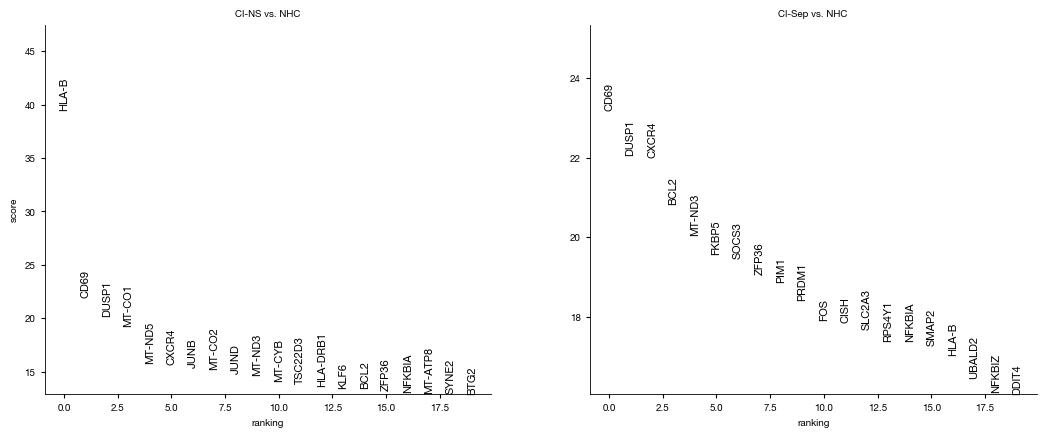

In [195]:
# Define the comparison groups
group_key = 'Group'
reference_group = 'NHC'

# Initialize a dictionary to store DEGs for each cell type
degs_dict = {}

# Loop through each specified cell type and perform differential expression
for cell_type in cell_types_of_interest:
    # Subset further to each cell type
    adata_cell_type = adata_subset[adata_subset.obs['celltype_fine'] == cell_type].copy()
    
    # Run differential expression analysis comparing CI-Sep vs NHC
    sc.tl.rank_genes_groups(
        adata_cell_type, 
        groupby=group_key, 
        reference=reference_group, 
        method='wilcoxon'
    )

    # Store the results in the dictionary
    degs_dict[cell_type] = adata_cell_type

    # Plot the top 20 DEGs for this cell type
    sc.pl.rank_genes_groups(adata_cell_type, n_genes=20, sharey=False)

In [7]:
adata

AnnData object with n_obs × n_vars = 644147 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'highlight', 'leiden-sub', 'celltype_coarse', 'celltype_fine', 'umap_x', 'umap_y', 'group_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', 'Biologic_Sex_colors', 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_coarse_colors', 'celltype_fine_colors', 'group_density_params', 'highlight_colors', 'hvg', 'leiden', 'leiden-sub_colors', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'
    ob

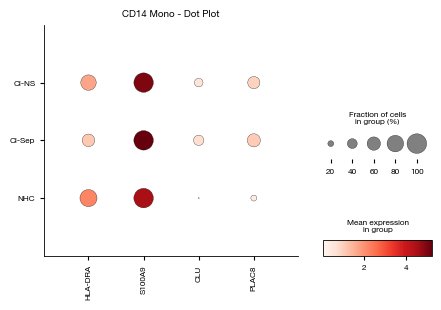

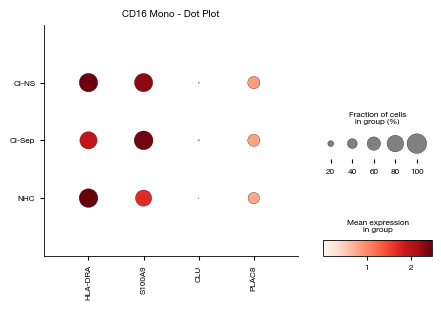

In [8]:
# Subset the adata object to include only CD14 Mono and CD16 Mono
adata_subset = adata[adata.obs['celltype_fine'].isin(['CD14 Mono', 'CD16 Mono'])].copy()

# Define genes of interest
genes_of_interest = ['HLA-DRA', 'S100A9', 'CLU', 'PLAC8']  # Adjust gene names as per your dataset

# Dot plot for CD14 Mono
adata_cd14 = adata_subset[adata_subset.obs['celltype_fine'] == 'CD14 Mono']
sc.pl.dotplot(
    adata_cd14,
    var_names=genes_of_interest,
    groupby='Group',
    title='CD14 Mono - Dot Plot',
    figsize=(5, 3)
)

# Dot plot for CD16 Mono
adata_cd16 = adata_subset[adata_subset.obs['celltype_fine'] == 'CD16 Mono']
sc.pl.dotplot(
    adata_cd16,
    var_names=genes_of_interest,
    groupby='Group',
    title='CD16 Mono - Dot Plot',
    figsize=(5, 3)
)

plt.show()

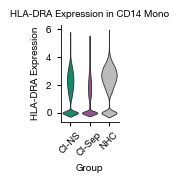

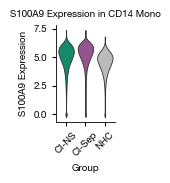

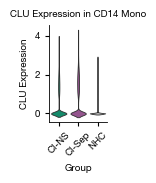

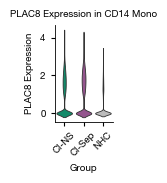

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse

# Subset the data to CD14 Mono
cd14_mono = adata[adata.obs['celltype_fine'] == 'CD14 Mono']

# Define genes of interest and color palette
genes_of_interest = ['HLA-DRA', 'S100A9', 'CLU', 'PLAC8']
group_palette = {'import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc

# Cytotoxic module gene list from Szabo et al. 2019
cytotoxic_genes = [
    "CCL5", "GZMK", "GNLY", "TRGC2", "FGFBP2", "C1orf21", "KLRF1", "FCGR3A", "PTGDR", "KLRC2",
    "EOMES", "S1PR5", "CLIC3", "AOAH", "CADM1", "TRGC1", "DTHD1", "LILRB1", "SAMD3", "ZNF683",
    "KLRD1", "NCR1", "FAM49A", "KLRG1", "CTSW", "CD244", "CMC1", "APOBEC3H", "CST7", "CX3CR1",
    "FCRL6", "TMCC3", "PLA2G16", "TYROBP", "TPRG1", "C12orf75", "PLCG2", "PLEK", "RCAN2", "DKK3",
    "ADRB2", "FCRL3", "NKG7", "PPP2R2B", "SYNGR1", "KLRC4", "HLA-DPB1", "DAPK2", "F2R", "KIR3DL2",
    "B3GAT1", "CD8B", "TTC16", "GALNT3", "SCD5", "PDGFD", "ABCB1", "MXRA7", "CTBP2", "CD8A",
    "ZEB2", "SYTL2", "CHN2", "FGR", "TGFBR3", "SETBP1", "COLGALT2", "KIR2DL4", "FKBP1B", "ADGRG1"
]

# Prepare the gene expression matrix and metadata
expression_matrix = pd.DataFrame(
    cd8_eff_em.X.todense(),  # Convert sparse matrix to dense
    index=cd8_eff_em.obs_names,
    columns=cd8_eff_em.var_names
)

# Create a DataFrame for the Cytotoxic module
cytotoxic_matrix = pd.DataFrame({'geneset': 'Cytotoxic', 'genesymbol': cytotoxic_genes})

# Run AUCell for the Cytotoxic module
auc_scores = dc.run_aucell(
    mat=expression_matrix, 
    net=cytotoxic_matrix, 
    source='geneset', 
    target='genesymbol',
    seed=28,
    verbose=True
)

# Add AUCell scores to the AnnData object
cd8_eff_em.obs['Cytotoxic_Module'] = auc_scores.loc[:, 'Cytotoxic']

# Define custom colors and group order
custom_palette = ['#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96']  # Grey, green, purple
group_order = ['NHC', 'CI-NS', 'CI-Sep']

# Create a violin plot
plt.figure(figsize=(0.75, 1.25))
sns.violinplot(
    x="Group", y="Cytotoxic_Module", data=cd8_eff_em.obs,
    inner=None, scale="width", palette=custom_palette, order=group_order
)

# Add means as a black bar
group_means = cd8_eff_em.obs.groupby('Group')['Cytotoxic_Module'].mean()
for i, (group, mean) in enumerate(group_means[group_order].items()):
    plt.plot([i - 0.2, i + 0.2], [mean, mean], color="black", linewidth=1.5)

# Add plot labels
plt.title("")
plt.ylabel("AUCell Score")
plt.xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

# Show the plot
plt.show()
}

# Create a violin plot for each gene
for gene in genes_of_interest:
    # Check if the gene exists in the dataset
    if gene not in adata.var_names:
        print(f"Gene {gene} not found in adata.var_names. Skipping.")
        continue

    # Extract gene expression values
    gene_expression = cd14_mono[:, gene].X.toarray().flatten() if issparse(cd14_mono.X) else cd14_mono[:, gene].X.flatten()

    # Set up the figure
    plt.figure(figsize=(0.75, 1.25))

    # Create the violin plot
    sns.violinplot(
        x=cd14_mono.obs['Group'],
        y=gene_expression,
        scale='width',
        palette=group_palette,
        inner=None,  # Do not show individual dots inside the violins
        linewidth=0.6
    )

    # Customize plot
    plt.title(f"{gene} Expression in CD14 Mono")
    plt.xlabel("Group")
    plt.ylabel(f"{gene} Expression")
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc

# Subset to CD14 Mono
cd14_mono = adata[adata.obs['celltype_fine'] == 'CD14 Mono']

# Define the MS1 gene set
ms1_genes = [
    'RETN', 'ALOX5AP', 'CD63', 'SEC61G', 'TXN', 'MT1X', 'FOS', 'SOD2', 'NCF1', 'IL1R2', 'THBS1', 'DPYSL2',
    'PTPRE', 'C6orf62', 'FES', 'CD164', 'TM9SF2', 'PRKAR1A', 'SLC25A37', 'YWHAE', 'PTEN', 'SLC38A2', 'A1BG',
    'CSNK1A1', 'ADAM10', 'TRABD', 'LILRA5', 'TLN1', 'DYNC1I2', 'CSF2RB', 'ITGAE', 'IL1RN', 'LPXN', 'RRBP1',
    'SNHG25', 'FOSL2', 'CAPZA1', 'FKBP2', 'HNRNPM', 'GOLPH3', 'JAK3', 'SLC16A7', 'ESRRA', 'YY1', 'RAB1B',
    'MYL12A', 'NUFIP2', 'CTBP1', 'BIRC2', 'SLC15A4', 'LENG8', 'TDG', 'DNAJC3', 'COLGALT1', 'TNFAIP6',
    'TMEM33', 'APP', 'UQCC3', 'OGT', 'DNAJC7', 'CST7', 'EIF3J', 'CERS6', 'TBL1XR1', 'IRAK1', 'YTHDF3',
    'ADAM17', 'ST14', 'SMG7', 'PUM2', 'PRPF4B', 'CDK2AP2', 'PHACTR2', 'MGST2', 'KIAA0319L', 'ABCA7',
    'MGAT4A', 'SFT2D2', 'COX20', 'TES', 'MT1G', 'AP2B1', 'ADAM19', 'HIP1', 'PABPN1', 'NCOA3', 'INTS6',
    'UPF2', 'METAP2', 'BRI3BP', 'NUP50', 'HIST1H4C', 'IGHA1', 'HBB', 'APMAP', 'EXOC5', 'CHD3', 'PNKD',
    'FBXW5', 'MAPKAPK2', 'PTPN22', 'TNKS2', 'ARF4', 'ATP2A3', 'POR', 'MT-ATP8', 'ADAM8', 'MKL1', 'SUPT5H',
    'FBXL15', 'DNAJB11', 'HNRNPAB', 'TRAM1', 'DNM2', 'STAG2', 'HERPUD1', 'RSBN1L', 'DR1', 'MAN2A1', 'YTHDC1',
    'GSN', 'NUCB2', 'LLNLR-245B6.1', 'COPG1', 'PTPRA', 'AP2A2', 'CBX6', 'AC004556.1', 'RREB1', 'NXF1',
    'UHMK1', 'TRG-AS1', 'DENND4B', 'AP3M1', 'COMTD1', 'PLCB2', 'CNOT1', 'HYOU1', 'RHBDF2', 'PTMS', 'PRKAA1',
    'TYK2', 'KIAA0100', 'DCTN1', 'XPO1', 'FBXW11', 'CYTH1', 'SMG1', 'UBE4A', 'HOPX', 'ARL6IP1', 'HSPB1',
    'NLRC5', 'IRF2BPL', 'SPTY2D1', 'ANP32E', 'AVL9', 'CH17-373J23.1', 'DDIT4', 'ZMPSTE24', 'PBX2', 'ACADVL',
    'POGZ', 'MED15', 'AP1G1', 'KRCC1', 'TIAL1', 'SEC23A', 'PSD4', 'ZNF516', 'MAP2K4', 'RASSF3', 'SMARCA5',
    'TTC1', 'ITGB7'
]

# Initialize the pathway-gene pair DataFrame
net = pd.DataFrame({"source": ["MS1 (Reyes et al., 2020)"] * len(ms1_genes), "target": ms1_genes})

# Subset the data for CD14 Mono
cd14_mono = adata[adata.obs['celltype_fine'] == 'CD14 Mono'].copy()

# Run AUCell for the MS1 gene set
dc.run_aucell(
    mat=cd14_mono, 
    net=net, 
    source='source', 
    target='target', 
    n_up=None, 
    min_n=5, 
    seed=28, 
    verbose=True
)

# Extract AUCell scores for the MS1 signature
cd14_mono.obs['MS1_AUCell'] = cd14_mono.obsm['aucell_estimate']['MS1 (Reyes et al., 2020)']

7558 features of mat are empty, they will be removed.
Running aucell on mat with 161174 samples and 29043 targets for 1 sources.


100%|█████████████████████████████████| 161174/161174 [1:07:29<00:00, 39.81it/s]


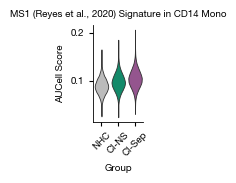

In [30]:
# Filter for NHC, CI-NS, and CI-Sep groups
filtered_cd14_mono = cd14_mono[cd14_mono.obs['Group'].isin(['NHC', 'CI-NS', 'CI-Sep'])]

# Define the color palette
palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

# Plot violin plot comparing NHC, CI-NS, and CI-Sep for MS1 signature
plt.figure(figsize=(0.65, 1.25))
sns.violinplot(
    data=filtered_cd14_mono.obs,
    x="Group",
    y="MS1_AUCell",
    order=['NHC', 'CI-NS', 'CI-Sep'],  # Ensure correct order
    scale="width",
    inner=None,  # No individual dots inside the violins
    palette=palette,
    linewidth=0.6
)

# Customize the plot
plt.title("MS1 (Reyes et al., 2020) Signature in CD14 Mono")
plt.xlabel("Group")
plt.ylabel("AUCell Score")
plt.xticks(rotation=45)
plt.show()


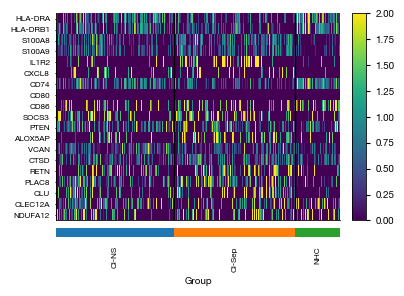

In [6]:
import scanpy as sc
import matplotlib.pyplot as plt

# Subset to CD14 Mono
cd14_mono = adata[adata.obs['celltype_fine'] == 'CD14 Mono']

# Use the raw layer for full gene set
cd14_mono_raw = cd14_mono.raw.to_adata()

# Define genes of interest
genes_of_interest = ['HLA-DRA', 'HLA-DRB1', 'S100A8', 'S100A9', 'IL1R2', 'CXCL8', 
                     'CD74', 'CD80', 'CD86', 'SOCS3', 'PTEN', 'ALOX5AP', 'VCAN', 'CTSD', 'RETN', 'PLAC8', 'CLU', 'CLEC12A', 'NDUFA12']

# Subset the raw data to only the genes of interest
cd14_mono_raw = cd14_mono_raw[:, genes_of_interest]

# Scale only the genes of interest
sc.pp.scale(cd14_mono_raw, zero_center=True)

# Plot the heatmap
sc.pl.heatmap(
    cd14_mono_raw,
    var_names=genes_of_interest,
    groupby="Group",  # Group by NHC, CI-NS, and CI-Sep
    vmin=0,  # Minimum z-score
    vmax=2,  # Maximum z-score
    cmap="viridis",  # Divergent colormap
    dendrogram=False,  # Show dendrogram
    swap_axes=True,  # Place genes on the y-axis
    figsize=(4, 3)  # Adjust figure size
)

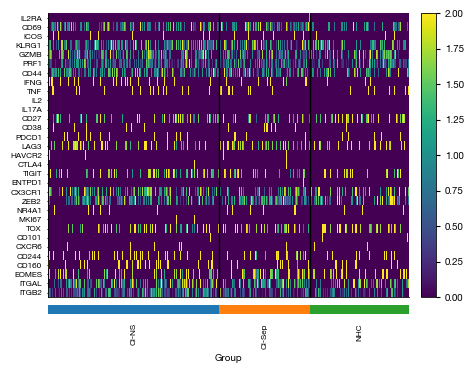

In [63]:
import scanpy as sc
import matplotlib.pyplot as plt

# Subset to CD14 Mono
cd14_mono = adata[adata.obs['celltype_fine'] == 'CD8 T Eff/EM']

# Use the raw layer for full gene set
cd14_mono_raw = cd14_mono.raw.to_adata()

# Define genes of interest
genes_of_interest = ['IL2RA', 'CD69', 'ICOS', 'KLRG1', 'GZMB', 'PRF1', 'CD44', 'IFNG', 'TNF', 'IL2', 'IL17A', 
                     'CD27', 'CD38', 'PDCD1', 'LAG3', 'HAVCR2', 'CTLA4', 'TIGIT', 'ENTPD1', 
                     'CX3CR1', 'ZEB2', 'NR4A1', 'MKI67',
                     'TOX', 'CD101', 'CXCR6', 'CD244', 'CD160', 'EOMES', 'ITGAL', 'ITGB2']

# Subset the raw data to only the genes of interest
cd14_mono_raw = cd14_mono_raw[:, genes_of_interest]

# Scale only the genes of interest
sc.pp.scale(cd14_mono_raw, zero_center=True)

# Plot the heatmap
sc.pl.heatmap(
    cd14_mono_raw,
    var_names=genes_of_interest,
    groupby="Group",  # Group by NHC, CI-NS, and CI-Sep
    vmin=0,  # Minimum z-score
    vmax=2,  # Maximum z-score
    cmap="viridis",  # Divergent colormap
    dendrogram=False,  # Show dendrogram
    swap_axes=True,  # Place genes on the y-axis
    figsize=(5, 4)  # Adjust figure size
)